In [1]:
import torch
import torch.nn as nn
from torch.optim import adam
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
BASE_DIR = "/home/sid/Drive_D/auto_encoders/" # Change this to your base directory
DATA_DIR = os.path.join(BASE_DIR, "data")

if not os.path.exists(DATA_DIR):
    print(f"{DATA_DIR} doesn't exist. Creating one!", DATA_DIR)
    os.mkdir(DATA_DIR)

# We will be working with the simplest image dataset out there: MNIST.

# Defining the transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales to [0, 1]
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Data augmentation
])

# Downloading the dataset

In [4]:
mnist_test = datasets.MNIST(DATA_DIR, transform=transform, download=True, train=False)
mnist_train = datasets.MNIST(DATA_DIR, transform=transform, download=True, train=True)

In [5]:
train_dataloader = DataLoader(mnist_train, 
                                batch_size=100,
                                shuffle=True,
                                num_workers=10
                             )
test_dataloader = DataLoader(mnist_test, 
                                batch_size=100,
                                shuffle=False,
                                num_workers=10
                             )

# Let's look at an image example from the training set

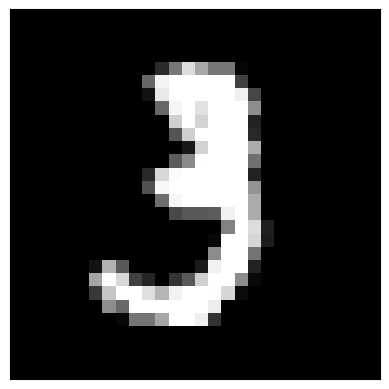

In [6]:
def plot_image(tensor_img):
    plt.imshow(transforms.ToPILImage()(tensor_img), cmap='gray')
    plt.xticks([])
    plt.yticks([]);
plot_image(mnist_train[10][0])

# Utility functions

In [210]:
def train(model, optimizer, criterion, train_loader, epochs):
    from tqdm import tqdm
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=True)
    
        for batch in progress_bar:
            image, _ = batch
            image = image.to(device)
            B, C,H, W = image.shape
            optimizer.zero_grad()
            logits = model.forward(image)
            loss = criterion(logits, image)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            # Update progress bar with loss
            progress_bar.set_postfix(loss=loss.item())
        
        print(f"Epoch {epoch+1}: Avg Loss: {running_loss / len(train_dataloader):.6f}")

In [211]:
@torch.no_grad()
def inference(model, input_tensor):
    C, W, H = input_tensor.shape
    reconstructed = input_tensor.reshape((C, -1))
    return reconstructed.view(C, W, H)

# Defining the FF Auto Encoder Module

In [212]:
class FFAutoencoder(nn.Module):
    
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, latent_dim), # bottle neck
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50), # bottle neck
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, C, W, H = x.shape
        x = self.encoder(x) # encoding
        x = self.decoder(x) # reconstruction
        return x.reshape(B, C, W, H)

# Training FFAE

In [213]:
# model configs
latent_dim = 25
input_dim = 784
epochs = 30

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FFAutoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
# model = ConvAutoencoder().to(device)
optimizer = adam.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [214]:
train(model=model,
     optimizer=optimizer,
     criterion=criterion,
     train_loader=train_dataloader,
     epochs=epochs)

Epoch 1: 100%|████████████████████████████████████████| 600/600 [00:03<00:00, 184.29it/s, loss=0.034]


Epoch 1: Avg Loss: 0.055246


Epoch 2: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 177.23it/s, loss=0.0273]


Epoch 2: Avg Loss: 0.029837


Epoch 3: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.70it/s, loss=0.0242]


Epoch 3: Avg Loss: 0.024393


Epoch 4: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.46it/s, loss=0.0196]


Epoch 4: Avg Loss: 0.020999


Epoch 5: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 166.18it/s, loss=0.0176]


Epoch 5: Avg Loss: 0.018762


Epoch 6: 100%|████████████████████████████████████████| 600/600 [00:03<00:00, 171.48it/s, loss=0.017]


Epoch 6: Avg Loss: 0.017156


Epoch 7: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.44it/s, loss=0.0164]


Epoch 7: Avg Loss: 0.016057


Epoch 8: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.83it/s, loss=0.0137]


Epoch 8: Avg Loss: 0.015155


Epoch 9: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.83it/s, loss=0.0133]


Epoch 9: Avg Loss: 0.014495


Epoch 10: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 175.18it/s, loss=0.0129]


Epoch 10: Avg Loss: 0.014068


Epoch 11: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 174.95it/s, loss=0.0129]


Epoch 11: Avg Loss: 0.013710


Epoch 12: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 163.83it/s, loss=0.0131]


Epoch 12: Avg Loss: 0.013325


Epoch 13: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 173.69it/s, loss=0.011]


Epoch 13: Avg Loss: 0.013030


Epoch 14: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 179.17it/s, loss=0.012]


Epoch 14: Avg Loss: 0.012746


Epoch 15: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 167.53it/s, loss=0.0122]


Epoch 15: Avg Loss: 0.012491


Epoch 16: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 167.02it/s, loss=0.0114]


Epoch 16: Avg Loss: 0.012297


Epoch 17: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 168.85it/s, loss=0.0132]


Epoch 17: Avg Loss: 0.012166


Epoch 18: 100%|█████████████████████████████████████| 600/600 [00:03<00:00, 166.75it/s, loss=0.00977]


Epoch 18: Avg Loss: 0.011998


Epoch 19: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 169.30it/s, loss=0.0124]


Epoch 19: Avg Loss: 0.011875


Epoch 20: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 163.67it/s, loss=0.0115]


Epoch 20: Avg Loss: 0.011754


Epoch 21: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 162.25it/s, loss=0.0112]


Epoch 21: Avg Loss: 0.011656


Epoch 22: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.88it/s, loss=0.012]


Epoch 22: Avg Loss: 0.011524


Epoch 23: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 175.26it/s, loss=0.0121]


Epoch 23: Avg Loss: 0.011444


Epoch 24: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 175.12it/s, loss=0.011]


Epoch 24: Avg Loss: 0.011352


Epoch 25: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 171.10it/s, loss=0.0104]


Epoch 25: Avg Loss: 0.011255


Epoch 26: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 178.79it/s, loss=0.0108]


Epoch 26: Avg Loss: 0.011140


Epoch 27: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 171.94it/s, loss=0.0108]


Epoch 27: Avg Loss: 0.011044


Epoch 28: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 173.21it/s, loss=0.0103]


Epoch 28: Avg Loss: 0.010963


Epoch 29: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 174.43it/s, loss=0.0112]


Epoch 29: Avg Loss: 0.010892


Epoch 30: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 164.67it/s, loss=0.0113]

Epoch 30: Avg Loss: 0.010801


# Defining the Convolution Auto Encoder 

In [222]:
class ConvAutoencoder(nn.Module):
    def __init__(self, n_channels=1):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, n_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H , W = x.shape
        x = self.encoder(x)
        x = self.decoder(x)
        return x[...,2:-2,2:-2]

# Training ConvAE

In [223]:
# model configs
epochs = 30
in_channels = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvAutoencoder(n_channels=in_channels).to(device)
optimizer = adam.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [224]:
train(model, optimizer, criterion, train_dataloader, epochs)

Epoch 1: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 177.96it/s, loss=0.0993]


Epoch 1: Avg Loss: 0.099810


Epoch 2: 100%|████████████████████████████████████████| 600/600 [00:03<00:00, 177.76it/s, loss=0.101]


Epoch 2: Avg Loss: 0.099059


Epoch 3: 100%|████████████████████████████████████████| 600/600 [00:03<00:00, 177.64it/s, loss=0.107]


Epoch 3: Avg Loss: 0.099003


Epoch 4: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 172.15it/s, loss=0.0972]


Epoch 4: Avg Loss: 0.099051


Epoch 5: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 174.05it/s, loss=0.0969]


Epoch 5: Avg Loss: 0.099068


Epoch 6: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 171.95it/s, loss=0.0976]


Epoch 6: Avg Loss: 0.099105


Epoch 7: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 172.31it/s, loss=0.0998]


Epoch 7: Avg Loss: 0.099033


Epoch 8: 100%|██████████████████████████████████████████| 600/600 [00:03<00:00, 178.37it/s, loss=0.1]


Epoch 8: Avg Loss: 0.099002


Epoch 9: 100%|████████████████████████████████████████| 600/600 [00:03<00:00, 165.26it/s, loss=0.102]


Epoch 9: Avg Loss: 0.099083


Epoch 10: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 170.28it/s, loss=0.0997]


Epoch 10: Avg Loss: 0.099028


Epoch 11: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 168.64it/s, loss=0.0928]


Epoch 11: Avg Loss: 0.099027


Epoch 12: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 166.62it/s, loss=0.093]


Epoch 12: Avg Loss: 0.099122


Epoch 13: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 168.72it/s, loss=0.0899]


Epoch 13: Avg Loss: 0.099077


Epoch 14: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 163.38it/s, loss=0.098]


Epoch 14: Avg Loss: 0.099126


Epoch 15: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 164.04it/s, loss=0.105]


Epoch 15: Avg Loss: 0.099079


Epoch 16: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 174.53it/s, loss=0.101]


Epoch 16: Avg Loss: 0.099011


Epoch 17: 100%|█████████████████████████████████████████| 600/600 [00:03<00:00, 167.86it/s, loss=0.1]


Epoch 17: Avg Loss: 0.098995


Epoch 18: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 168.80it/s, loss=0.101]


Epoch 18: Avg Loss: 0.099001


Epoch 19: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 172.92it/s, loss=0.105]


Epoch 19: Avg Loss: 0.099073


Epoch 20: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 165.38it/s, loss=0.0971]


Epoch 20: Avg Loss: 0.099087


Epoch 21: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 168.85it/s, loss=0.106]


Epoch 21: Avg Loss: 0.099140


Epoch 22: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 172.93it/s, loss=0.098]


Epoch 22: Avg Loss: 0.099043


Epoch 23: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 174.81it/s, loss=0.098]


Epoch 23: Avg Loss: 0.099002


Epoch 24: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 169.91it/s, loss=0.0969]


Epoch 24: Avg Loss: 0.099126


Epoch 25: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 171.88it/s, loss=0.0971]


Epoch 25: Avg Loss: 0.098960


Epoch 26: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 163.98it/s, loss=0.104]


Epoch 26: Avg Loss: 0.099003


Epoch 27: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 172.68it/s, loss=0.0986]


Epoch 27: Avg Loss: 0.099016


Epoch 28: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 165.64it/s, loss=0.101]


Epoch 28: Avg Loss: 0.099141


Epoch 29: 100%|██████████████████████████████████████| 600/600 [00:03<00:00, 171.78it/s, loss=0.0962]


Epoch 29: Avg Loss: 0.099012


Epoch 30: 100%|███████████████████████████████████████| 600/600 [00:03<00:00, 166.12it/s, loss=0.101]

Epoch 30: Avg Loss: 0.099014


In [225]:
test_image = mnist_test[14][0]

In [226]:
generated = inference(model, test_image)

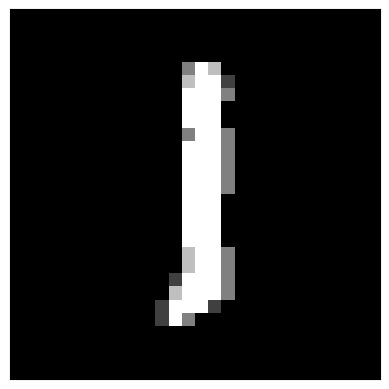

In [227]:
plot_image(test_image)

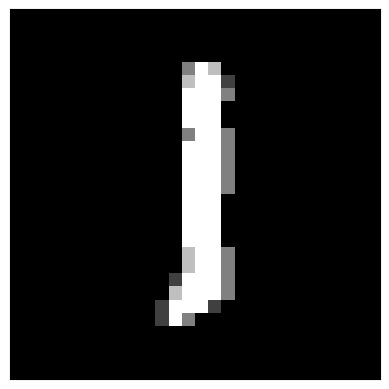

In [228]:
plot_image(generated)

In [219]:
torch.randn((100, 1, 32,32)).view((100, 1, -1)).shape

torch.Size([100, 1, 1024])